# 1. Introduction

# 1.2. A motivating example




In [1]:
from scipy import optimize
import ufl
import matplotlib.pyplot as plt
import sys
import cuqi
from cuqi.sampler import NUTS
from cuqi.problem import BayesianProblem
from cuqi.distribution import Gaussian
from cuqipy_fenics.testproblem import FEniCSPoisson2D
import dolfin as dl
import numpy as np

/Users/amal/opt/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
A = FEniCSPoisson2D(dim=(32,32), field_type="KL", mapping='exponential', bc_types=['Dirichlet', 'Neumann', 'Dirichlet', 'Neumann']).model

In [3]:
G_KL = A.domain_geometry
G_FEM = A.range_geometry

In [4]:
n_KL = G_KL.num_terms

In [5]:
x = Gaussian(np.zeros(n_KL), 1, geometry=G_KL)

In [6]:
# Set the random seed
np.random.seed(15) 

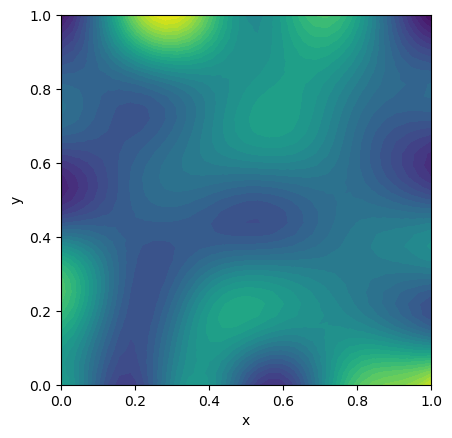

In [7]:
x_true = x.sample()
x_true.plot()

This cell to compute s_noise

In [8]:
noise_level = 0.01
y_true = A(x_true)
s_noise = 1.0/np.sqrt(G_FEM.par_dim)* noise_level*np.linalg.norm(y_true)

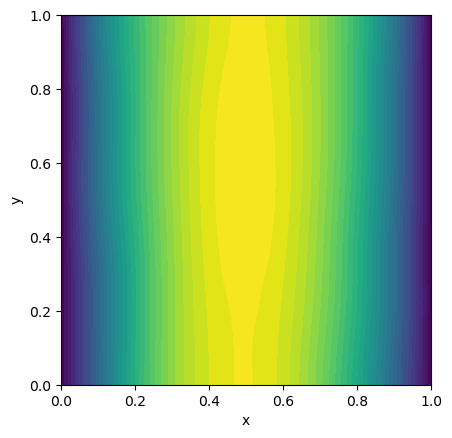

In [9]:
# to be fixed in future release to be y_true.plot()
G_FEM.plot(y_true)

In [10]:
y = Gaussian(A(x), s_noise**2, geometry=G_FEM)

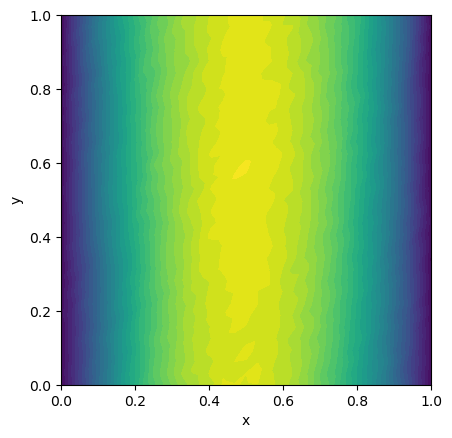

In [11]:
y_obs = y(x=x_true).sample()
y_obs.plot()

In [12]:
BP = BayesianProblem(y, x).set_data(y=y_obs)

The following 2 code cells will be replaced by `BP.UQ(97)` in upcoming release
of this notebook 

In [13]:
Ns = 5000
Ns_factor = 1
my_sampler = NUTS(BP.posterior)
posterior_samples = my_sampler.sample_adapt(int(Ns*Ns_factor), Nb=10)


/Users/amal/Documents/research_code/CUQI-DTU/CUQIpy/cuqi/sampler/_hmc.py:222: RuntimeWarning: overflow encountered in exp
  alpha_prime = min(1, np.exp(diff_Ham))     # logalpha_p = min(0, H_p - H)


Sample 5010 / 5010


 <ErrorbarContainer object of 3 artists>]

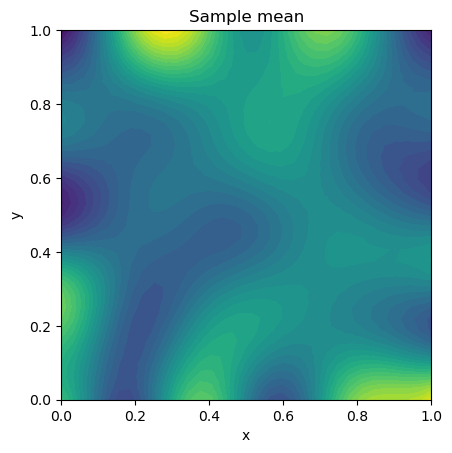

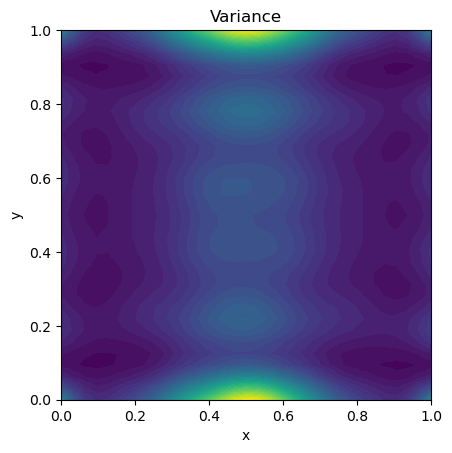

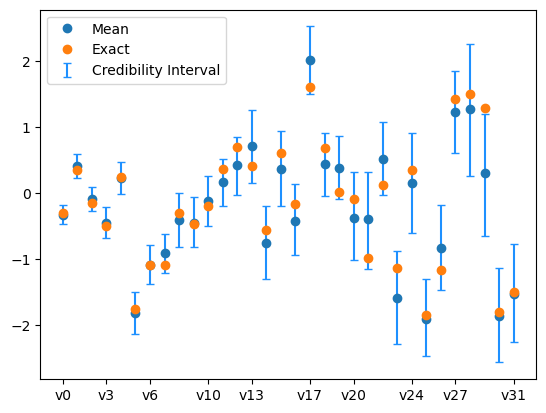

In [14]:
# plot mean
plt.figure()
posterior_samples.plot_mean()

# plot variance
# this logic of plotting the variance will be replaced by one line:
# `posterior_samples.funvals.plot_variance()` in future release
plt.figure()
dofs = np.empty((G_FEM.function_space.dim(),
                 posterior_samples.samples.shape[1]))
for i, s in enumerate(posterior_samples):
    dofs[:, i] = G_KL.par2fun(s).vector().get_local() 

var_vec = np.var(dofs, axis=1)
var_fun = dl.Function(G_FEM.function_space)
var_fun.vector().set_local(var_vec)
G_FEM.plot(var_fun, is_par=False)
plt.title('Variance')

# plot credible interval
plt.figure()
posterior_samples.plot_ci(97, plot_par=True, exact=x_true)

Code cell for generating Figure 1

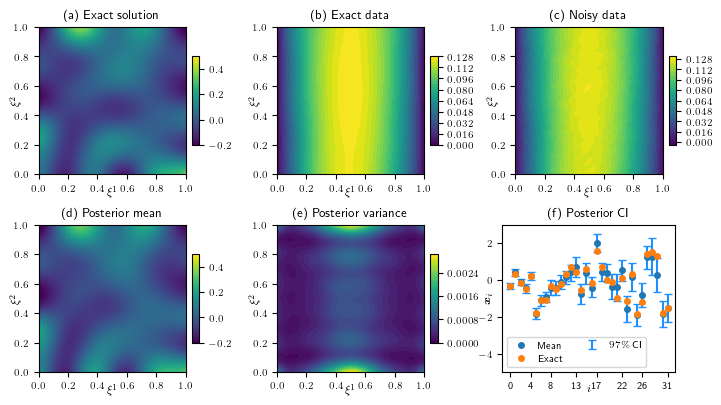

In [16]:
# Note: this code cell might need re-running if matplotlib raises an error at the first time
import os
from matplotlib import ticker

# Set up matplotlib
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 9
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Data directory
fig_dir = './figs/'

# Figure file
fig_dir = fig_dir 

# Check if the directory exists
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

# Figure version
version = 'v8'
n_burn = 0 # number of burn-in samples

# Figure file
fig_file = fig_dir + 'paper_figure1_'+version+'.pdf'

# Create the figure
cm_to_in = 1/2.54
fig, axs = plt.subplots(nrows=2, ncols=3,
                        figsize=(17.8*cm_to_in, 9.8*cm_to_in),
                        layout="constrained")


# Define the colors to be used in the plots
colors = ['C0', 'green', 'purple', 'k', 'gray']

# (a)
plt.sca(axs[0,0])
im = x_true.plot(subplots=False, vmin=-0.2, vmax=0.5, mode='color')
inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])
fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)
plt.gca().set_xlim(0, 1)
plt.gca().set_ylim(0, 1)
plt.gca().set_title('(a) Exact solution')

plt.ylabel('$\\xi^2$')
plt.gca().yaxis.labelpad = -5
plt.xlabel('$\\xi^1$')
plt.gca().xaxis.labelpad = -5

# (b)
plt.sca(axs[0,1])
# The following line will be replaced by `y_true.plot(subplots=False)` 
# in future release
im = G_FEM.plot(y_true, subplots=False)
inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])
fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)

plt.ylabel('$\\xi^2$')
plt.gca().yaxis.labelpad = -5
plt.xlabel('$\\xi^1$')
plt.gca().xaxis.labelpad = -5
plt.gca().set_title('(b) Exact data')

# (c)
plt.sca(axs[0,2])
im = y_obs.plot(subplots=False)
inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])
fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)

plt.ylabel('$\\xi^2$')
plt.gca().yaxis.labelpad = -5
plt.xlabel('$\\xi^1$')
plt.gca().xaxis.labelpad = -5
plt.gca().set_title('(c) Noisy data')

# (d)
plt.sca(axs[1,0])

im = posterior_samples.plot_mean(subplots=False, vmin=-0.2, vmax=0.5, mode='color')
inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])
fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)
plt.gca().set_xlim(0, 1)
plt.gca().set_ylim(0, 1)

plt.ylabel('$\\xi^2$')
plt.gca().yaxis.labelpad = -5
plt.xlabel('$\\xi^1$')
plt.gca().xaxis.labelpad = -5
plt.gca().set_title('(d) Posterior mean')

# (e)
plt.sca(axs[1,1])
im = G_KL.plot(var_fun, is_par=False,subplots=False)
inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])
cb = fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)
cb.locator = ticker.MaxNLocator(nbins=4)
plt.ylabel('$\\xi^2$')
plt.gca().yaxis.labelpad = -5
plt.xlabel('$\\xi^1$')
plt.gca().xaxis.labelpad = -5
plt.gca().set_title('(e) Posterior variance')

# (f)
plt.sca(axs[1,2])
lci = posterior_samples.burnthin(n_burn).plot_ci(97, exact=x_true, plot_par=True, markersize=SMALL_SIZE-3)
lci[0].set_label("Mean")
lci[1].set_label("Exact")
lci[2].set_label("$97\\%$ CI")
plt.ylim(-5, 3)
plt.legend(ncols=2) #

plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{bm}')
plt.ylabel('$\\bm{x}_i$')
plt.gca().yaxis.labelpad = -5
plt.gca().yaxis.set_label_coords( -0.06, 0.5)
plt.xlabel('$i$')
plt.gca().xaxis.labelpad = -5
plt.gca().set_title('(f) Posterior CI')
n_ticks = 8
num_var = posterior_samples.geometry.par_dim
tick_ids = np.linspace(0, num_var-1, n_ticks, dtype=int)
plt.xticks(tick_ids, tick_ids)

# Save the figure
fig.tight_layout(pad=0, w_pad=0.1, h_pad=0.9)
plt.savefig(fig_file, bbox_inches='tight', pad_inches=0.01, dpi=1200)